<a href="https://colab.research.google.com/github/bahramzada/Airline_Passenger_Satisfaction/blob/main/CatsVSDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
# Lazımi kitabxanaların quraşdırılması

In [ ]:
# Kitabxanaların idxalıimport torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset
import time
import matplotlib.pyplot as plt

In [ ]:
# Datasetin yüklənməsi
ds = load_dataset("microsoft/cats_vs_dogs")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [ ]:
# Datasetin təlim və test hissələrinə ayrılması
dataset = ds['train'].train_test_split(test_size = 0.2,
                                             seed = 42)

In [ ]:
# Datasetin strukturu
dataset

In [ ]:
# öz hazırladığım köməkçi funksiyanın yüklənməsi
!wget https://raw.githubusercontent.com/bahramzada/helperfunctions/refs/heads/main/helperFunction.py

--2025-07-17 05:05:47--  https://raw.githubusercontent.com/bahramzada/helperfunctions/refs/heads/main/helperFunction.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3697 (3.6K) [text/plain]
Saving to: ‘helperFunction.py’

helperFunction.py   100%[===================>]   3.61K  --.-KB/s    in 0s      

2025-07-17 05:05:47 (60.7 MB/s) - ‘helperFunction.py’ saved [3697/3697]



In [ ]:
# Köməkçi funksiyanın idxalı
from helperFunction import calculateMeanStdHF

In [ ]:
# Şəkillərin orta və standart sapmasının hesablanması
mean,std = calculateMeanStdHF(dataset['train'])
print(f'Train üçün orta: {mean}')
print(f'Train üçün standart sapma: {std}')

100%|██████████| 18728/18728 [01:51<00:00, 168.51it/s]

Train üçün orta: [0.48814481 0.45501252 0.41694422]
Train üçün standart sapma: [0.22945413 0.22490918 0.22535822]


In [ ]:
# Xüsusi Dataset sinfi
class HFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        image = image.convert("RGB")
        label = self.dataset[idx]['labels']
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Təlim və test datasetlərinin hazırlanması
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
# Şəkil transformasiyaları
train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224,scale = (0.8,1.)),
        transforms.ColorJitter(brightness=0.2 , contrast=0.2 , saturation=0.2 , hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std)
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std)
    ]
)

In [ ]:
# Datasetlərin transformasiya ilə yüklənməsi
train_data = HFDataset(train_dataset,transform = train_transform)
test_data = HFDataset(test_dataset,transform = test_transform)


In [ ]:
# DataLoader-ların hazırlanması
train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size = 32,shuffle = False)

In [ ]:
# Siniflərin sayının təyin edilməsi
num_classes = len(set(train_dataset['labels']))
print(num_classes)

2


In [ ]:
# Modelin hazırlanması (ResNet50)
model = models.resnet50(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [ ]:
# Cihazın təyin edilməsi (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Model, optimizator və itki funksiyasının cihaz üzərində qurulması
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Dəqiqlik funksiyası
def get_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    loss_total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    avg_loss = loss_total / total
    return acc, avg_loss

In [ ]:
# Təlim dövrü
num_epochs = 5
print("epoch no | train acc | train loss | test acc | test loss | vaxt(san)")
for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    train_avg_loss = train_loss / total

    # Test metrikaları
    test_acc, test_avg_loss = get_accuracy(test_loader, model)
    end_time = time.time()
    elapsed = end_time - start_time

    print(f"{epoch:9d} | {train_acc:9.4f} | {train_avg_loss:10.4f} | {test_acc:8.4f} | {test_avg_loss:9.4f} | {elapsed:8.2f}")

epoch no | train acc | train loss | test acc | test loss | vaxt(san)
        1 |    0.9746 |     0.0699 |   0.9910 |    0.0211 |   435.64
        2 |    0.9816 |     0.0493 |   0.9887 |    0.0285 |   432.13
        3 |    0.9854 |     0.0399 |   0.9872 |    0.0307 |   430.41
        4 |    0.9887 |     0.0323 |   0.9865 |    0.0359 |   429.66
        5 |    0.9884 |     0.0316 |   0.9891 |    0.0310 |   432.94


In [ ]:
# Səhv təxminləri göstərmək üçün funksiya
def show_wrong_predictions(model, loader, class_names, device, mean, std, max_samples=10):
    model.eval()
    wrong_images = []
    wrong_preds = []
    wrong_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            wrong_mask = preds != labels
            if wrong_mask.any():
                wrong_images.append(images[wrong_mask].cpu())
                wrong_preds.extend(preds[wrong_mask].cpu().tolist())
                wrong_labels.extend(labels[wrong_mask].cpu().tolist())
            if len(wrong_preds) >= max_samples:
                break

    # Bütün yanlışları tək bir tensorda birləşdirmək
    if not wrong_images:
        print("Yanlış təxmin yoxdur!")
        return
    wrong_images = torch.cat(wrong_images, dim=0)[:max_samples]
    wrong_preds = wrong_preds[:max_samples]
    wrong_labels = wrong_labels[:max_samples]

    # Görüntüləri nümayiş etdirmək
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )

    plt.figure(figsize=(15, 3 * ((max_samples + 4)//5)))
    for i in range(len(wrong_images)):
        img = inv_normalize(wrong_images[i])
        img = img.permute(1, 2, 0).numpy().clip(0, 1)
        plt.subplot((max_samples + 4)//5, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Həqiqi: {class_names[wrong_labels[i]]}\nTəxmin: {class_names[wrong_preds[i]]}", color="red")
    plt.tight_layout()
    plt.show()

In [ ]:
def count_wrong_predictions(model, loader, device):
    model.eval()
    total_wrong = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total_wrong += (preds != labels).sum().item()
            total += labels.size(0)
    print(f"Səhv təxmin sayı: {total_wrong}")
    print(f"Toplam test sayı: {total}")
    print(f"Accuracy: {(total - total_wrong) / total:.4f}")




In [ ]:
count_wrong_predictions(model, test_loader, device)

Yanlış tahmin sayısı: 51
Toplam test örneği: 4682
Doğruluk oranı: 0.9891


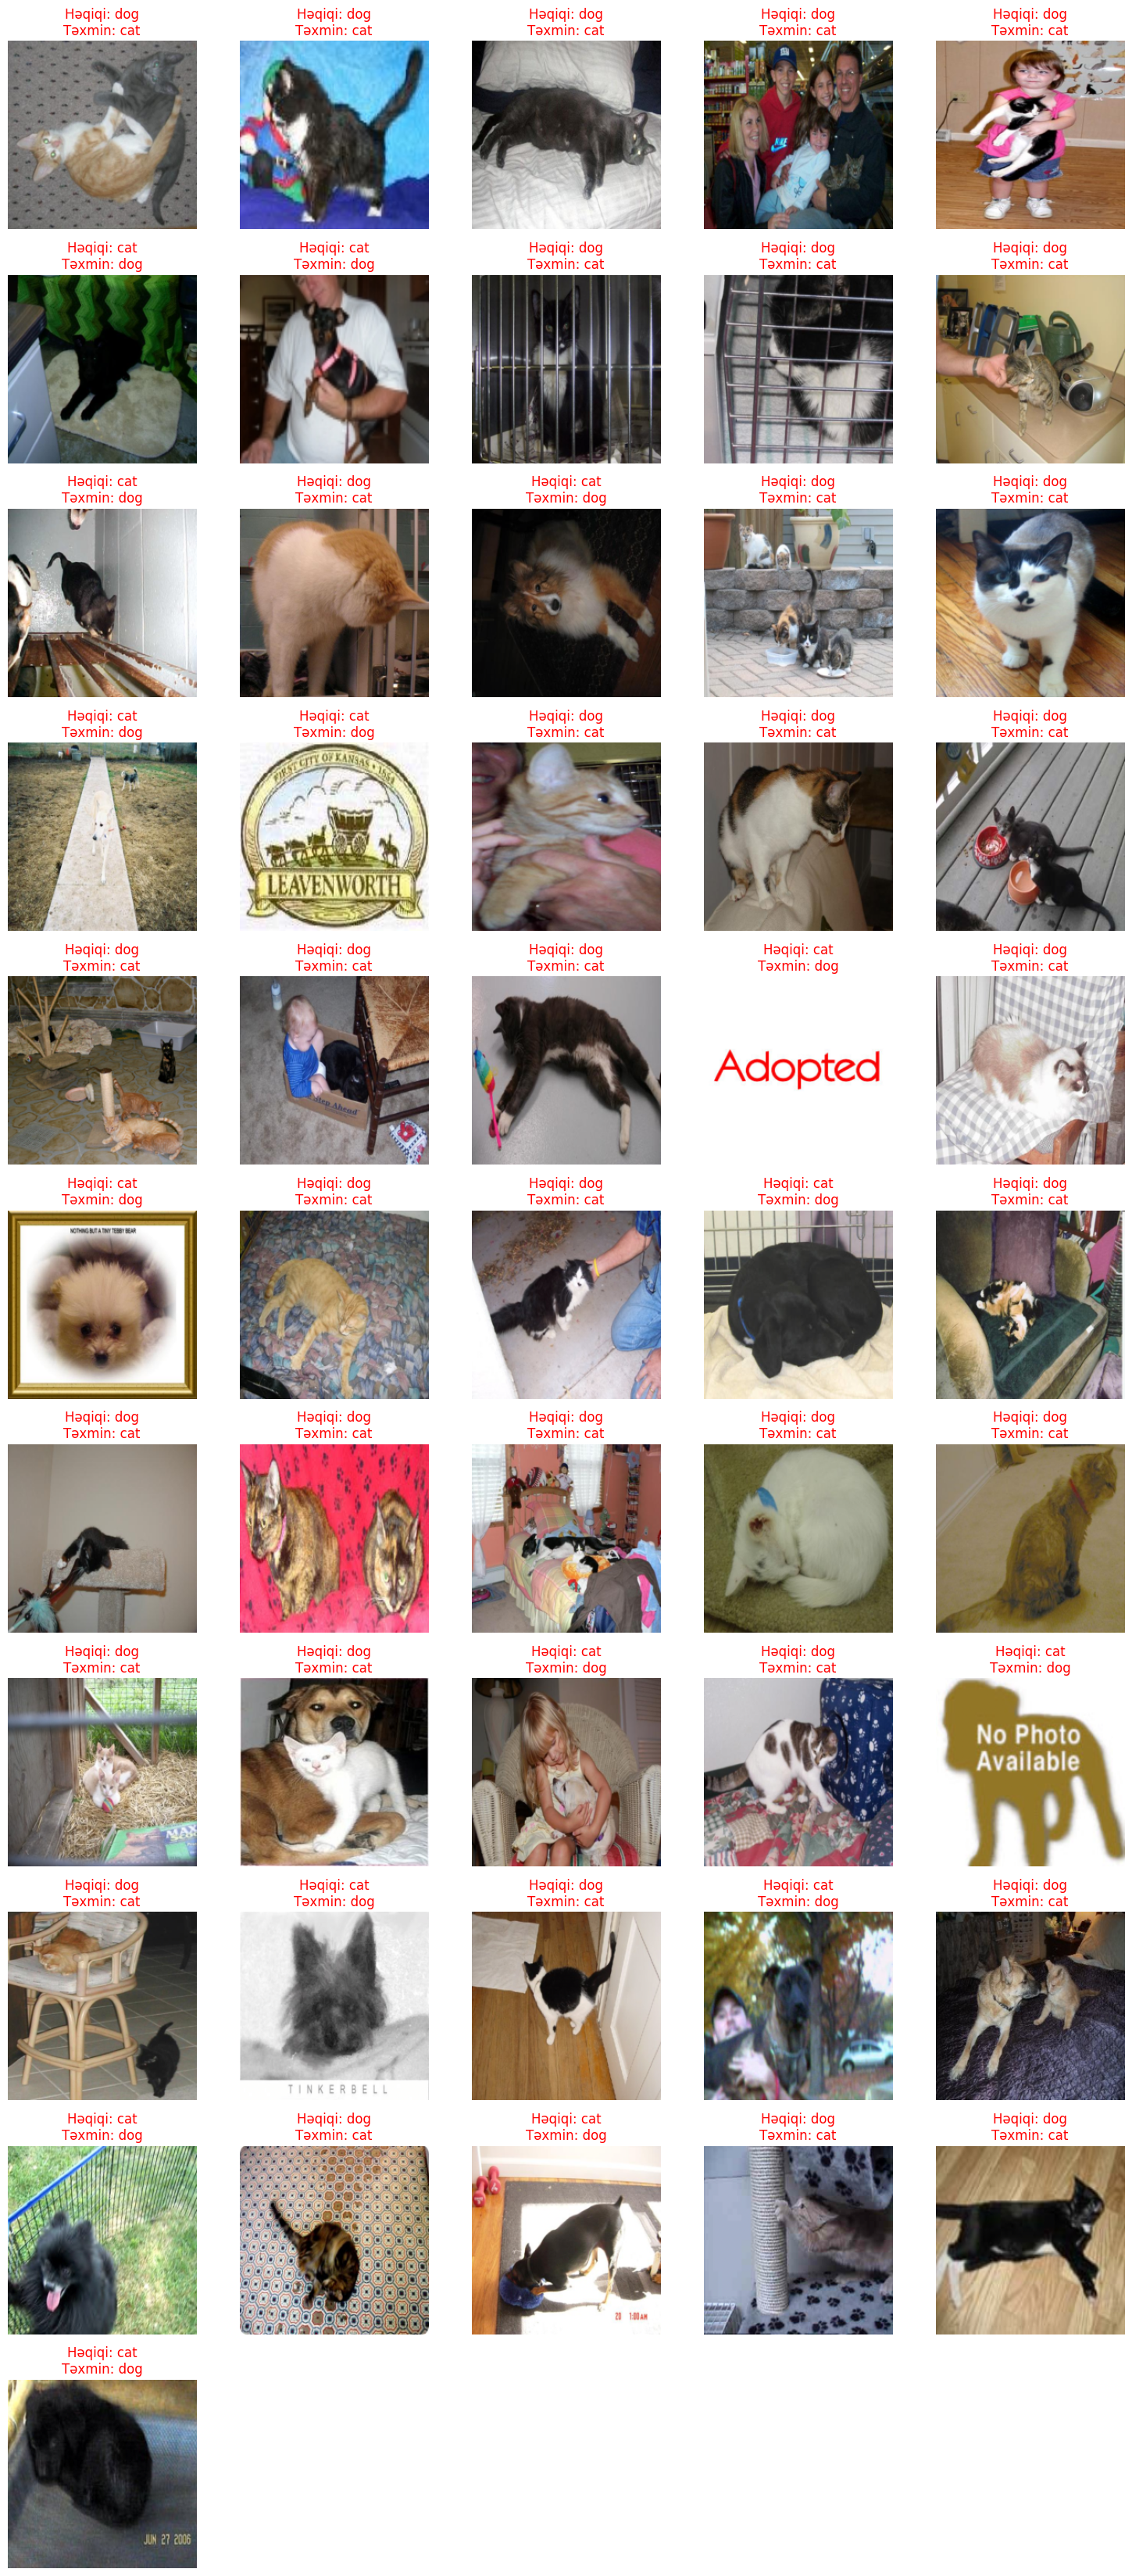

In [ ]:
# Səhv təxminlərin nümayişi
class_names = ["cat","dog"]
show_wrong_predictions(model, test_loader, class_names, device, mean, std, 100)